In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
import seaborn as sns
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import unitroot_adf
import itertools
import warnings
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import acf,pacf,plot_acf,plot_pacf

In [2]:
from read_table import *
table = read_table()
data = table["1"].iloc[:-1,:]
data.index = pd.to_datetime(data['date'])

(280, 6)


#### 画出原始数据的时间路径图

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


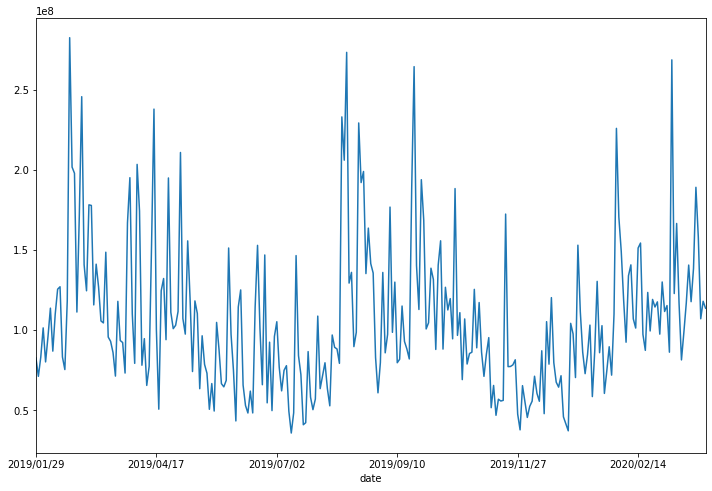

In [3]:
time_series = pd.Series(data.volume)
time_series.index = pd.Index(read_table()["1"].date[:-1])
time_series.plot(figsize=(12,8))
plt.show()

#### 查看平稳度

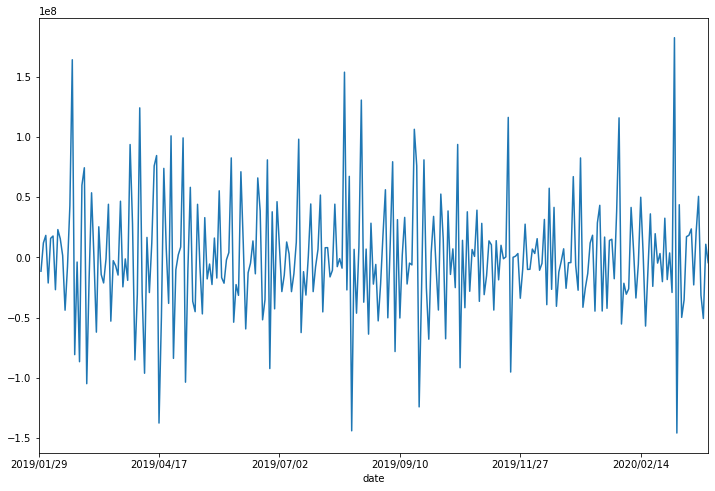

In [4]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
diff1 = time_series.diff(1)
diff1.plot(ax=ax1)

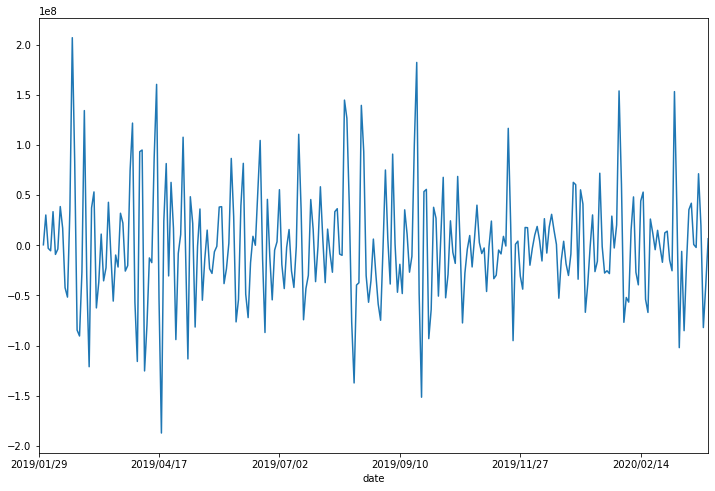

In [5]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
diff2 = time_series.diff(2)
diff2.plot(ax=ax1)

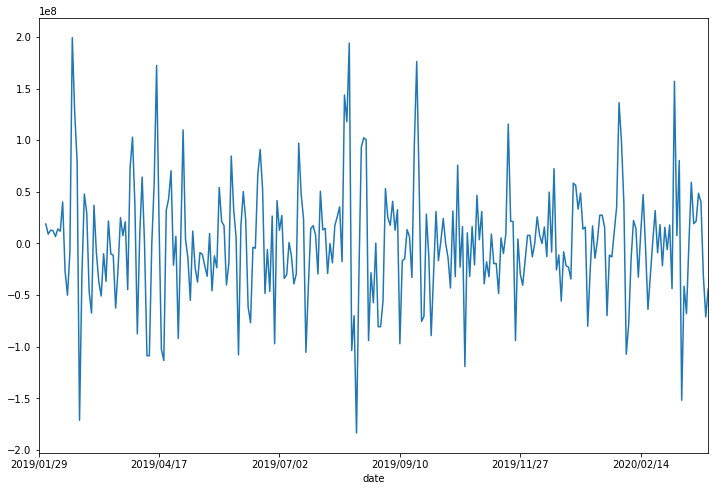

In [6]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(111)
diff3 = time_series.diff(3)
diff3.plot(ax=ax1)

#### 自相关和偏相关

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


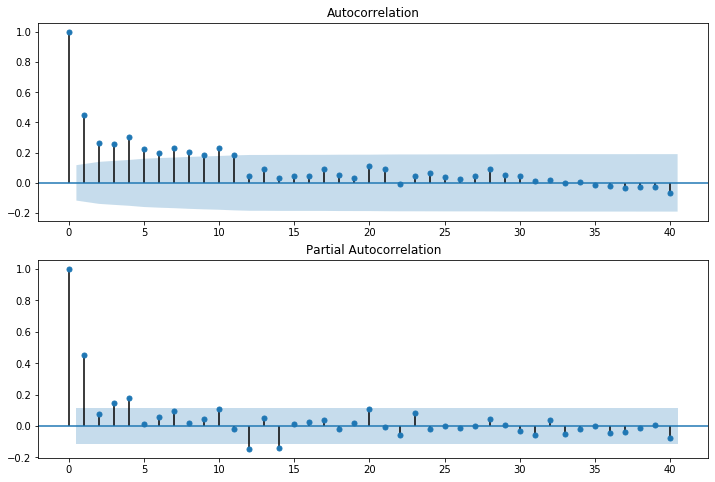

In [7]:
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(time_series,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(time_series,lags=40,ax=ax2)

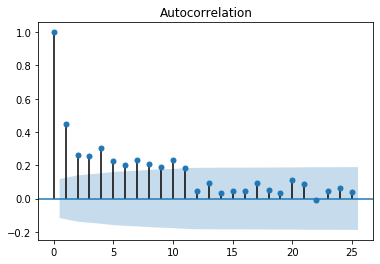

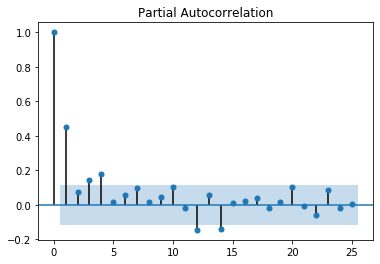

     lag        AC           Q       PAC      Prob(>Q)
0    1.0  0.450220   57.163153  0.450220  4.011163e-14
1    2.0  0.261482   76.514693  0.073729  2.426864e-17
2    3.0  0.255168   95.009713  0.142413  1.837503e-20
3    4.0  0.305857  121.679219  0.172816  2.338622e-25
4    5.0  0.226143  136.311951  0.012779  1.087372e-27
5    6.0  0.199960  147.794447  0.056674  2.263719e-29
6    7.0  0.231846  163.287649  0.091918  6.517890e-32
7    8.0  0.206442  175.616956  0.017940  8.563297e-34
8    9.0  0.186878  185.757523  0.040831  3.175599e-35
9   10.0  0.230880  201.293256  0.100815  8.672432e-38
10  11.0  0.184784  211.281811 -0.019366  3.371658e-39
11  12.0  0.043823  211.845720 -0.139058  1.161034e-38
12  13.0  0.093545  214.424809  0.051207  1.472372e-38
13  14.0  0.030536  214.700665 -0.130439  5.377253e-38
14  15.0  0.043323  215.258026  0.010216  1.657696e-37
15  16.0  0.045653  215.879307  0.022228  4.798083e-37
16  17.0  0.092115  218.418322  0.036688  5.513197e-37
17  18.0  

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [8]:
plot_acf(time_series)
plot_pacf(time_series)
plt.show()

r,rac,Q = sm.tsa.acf(time_series, qstat=True)
prac = pacf(time_series,method='ywmle')
table_data = np.c_[range(1,len(r)), r[1:],rac,prac[1:len(rac)+1],Q]
table = pd.DataFrame(table_data, columns=['lag', "AC","Q", "PAC", "Prob(>Q)"])

print(table)

In [9]:
(p, q) =(sm.tsa.arma_order_select_ic(time_series,max_ar=3,max_ma=3,ic='aic')['aic_min_order'])

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


#### Model Selection

In [11]:
arma = sm.tsa.ARMA(time_series,(p,q)).fit()
print(arma.aic,arma.bic,arma.hqic)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


10567.809082051353 10596.858776305924 10579.462276540145


#### 残差序列

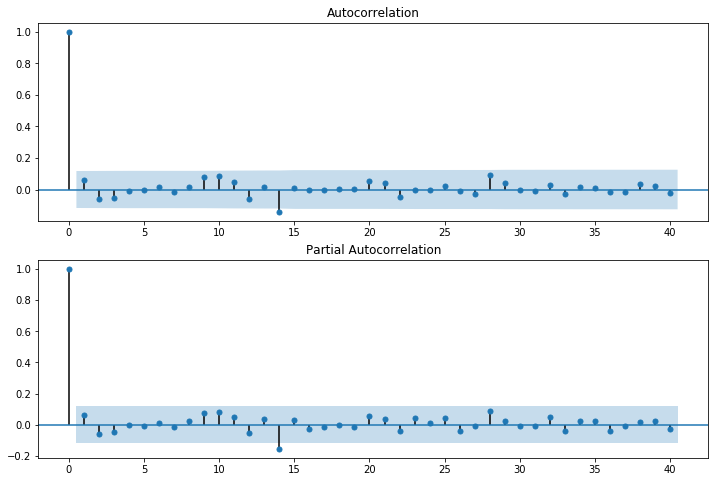

In [12]:
resid = arma.resid

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)
plt.show()

#### DW 检验

In [13]:
print(sm.stats.durbin_watson(arma.resid.values))

1.8786285455366714


#### 是否符合正态分布

NormaltestResult(statistic=85.53704323463492, pvalue=2.666042463887349e-19)


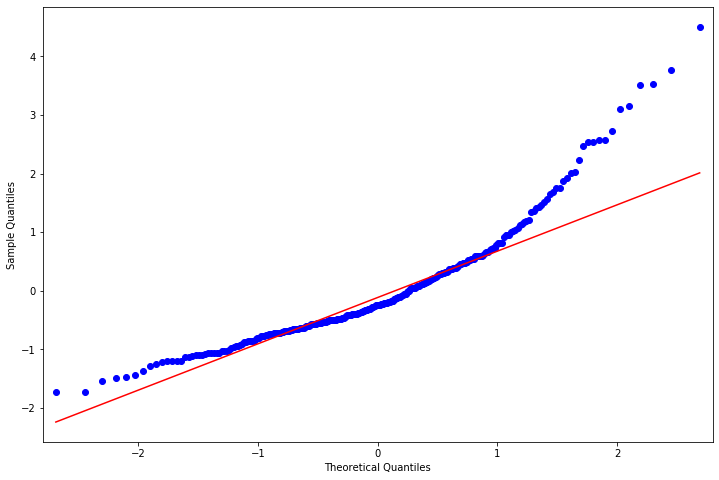

In [14]:
from scipy import  stats
from statsmodels.graphics.api import qqplot
print(stats.normaltest(resid))
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
#plt.show()

#### Q检验

In [15]:
r,q,p = sm.tsa.acf(resid.values.squeeze(), qstat=True)
data = np.c_[range(1,41), r[1:], q, p]
table = pd.DataFrame(data, columns=['lag', "AC", "Q", "Prob(>Q)"])
print(table.set_index('lag'))

            AC          Q  Prob(>Q)
lag                                
1.0   0.059521   0.999097  0.317529
2.0  -0.057956   1.949772  0.377235
3.0  -0.051476   2.702448  0.439811
4.0  -0.007611   2.718962  0.605901
5.0  -0.002036   2.720147  0.743035
6.0   0.014339   2.779195  0.836006
7.0  -0.013917   2.835019  0.899833
8.0   0.018044   2.929214  0.938721
9.0   0.077174   4.658575  0.862998
10.0  0.084585   6.743764  0.749393
11.0  0.046739   7.382807  0.767290
12.0 -0.059324   8.416183  0.751820
13.0  0.012786   8.464364  0.812088
14.0 -0.140249  14.283544  0.428808
15.0  0.010702  14.317554  0.501594
16.0 -0.005419  14.326309  0.574419
17.0 -0.003439  14.329848  0.643631
18.0  0.000794  14.330037  0.707337
19.0  0.004127  14.335173  0.763814
20.0  0.054179  15.223698  0.763468
21.0  0.040562  15.723656  0.784971
22.0 -0.050283  16.494947  0.790586
23.0 -0.001222  16.495404  0.833256
24.0 -0.002424  16.497211  0.869299
25.0  0.022494  16.653381  0.893980
26.0 -0.012522  16.701970  0

#### 预测

In [16]:
time_series

date
2019/01/29     82663112
2019/01/30     71200104
2019/01/31     83162272
2019/02/01    101427008
2019/02/11     80193664
                ...    
2020/03/19    189145712
2020/03/20    157835296
2020/03/23    107111360
2020/03/24    118020024
2020/03/25    113695776
Name: volume, Length: 279, dtype: int64

date
2020/03/09    1.131970e+08
2020/03/10    1.237228e+08
2020/03/11    1.462380e+08
2020/03/12    1.147573e+08
2020/03/13    1.085027e+08
2020/03/16    1.375907e+08
2020/03/17    1.196668e+08
2020/03/18    9.983476e+07
2020/03/19    1.265541e+08
2020/03/20    1.245077e+08
2020/03/23    9.756834e+07
2020/03/24    1.149446e+08
2020/03/25    1.268432e+08
dtype: float64


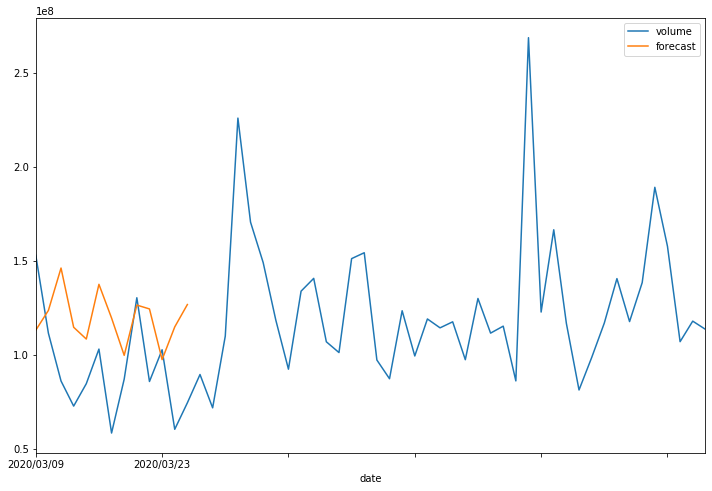

In [22]:
predict_dta = arma.predict('2020/03/09', '2020/03/25', dynamic=True)
print(predict_dta)


fig, ax = plt.subplots(figsize=(12, 8))
ax = time_series.loc['2020-03-01':].plot(ax=ax)
fig = arma.plot_predict('2020/03/09', '2020/03/25', dynamic=True, ax=ax, plot_insample=False)
plt.show()

In [23]:
n_steps = 21

f, err95, ci95 = arma.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = arma.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range("2020/04/03", periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2020-04-03,9.547614e+07,1.890897e+07,-5.150185e+06,1.720433e+08,1.961025e+08
2020-04-04,1.147737e+08,3.409410e+07,8.742726e+06,1.954533e+08,2.208047e+08
2020-04-05,1.318766e+08,4.950844e+07,2.362650e+07,2.142447e+08,2.401266e+08
2020-04-06,9.978579e+07,1.687082e+07,-9.182953e+06,1.827008e+08,2.087545e+08
2020-04-07,1.027880e+08,1.801494e+07,-8.622691e+06,1.875611e+08,2.141987e+08


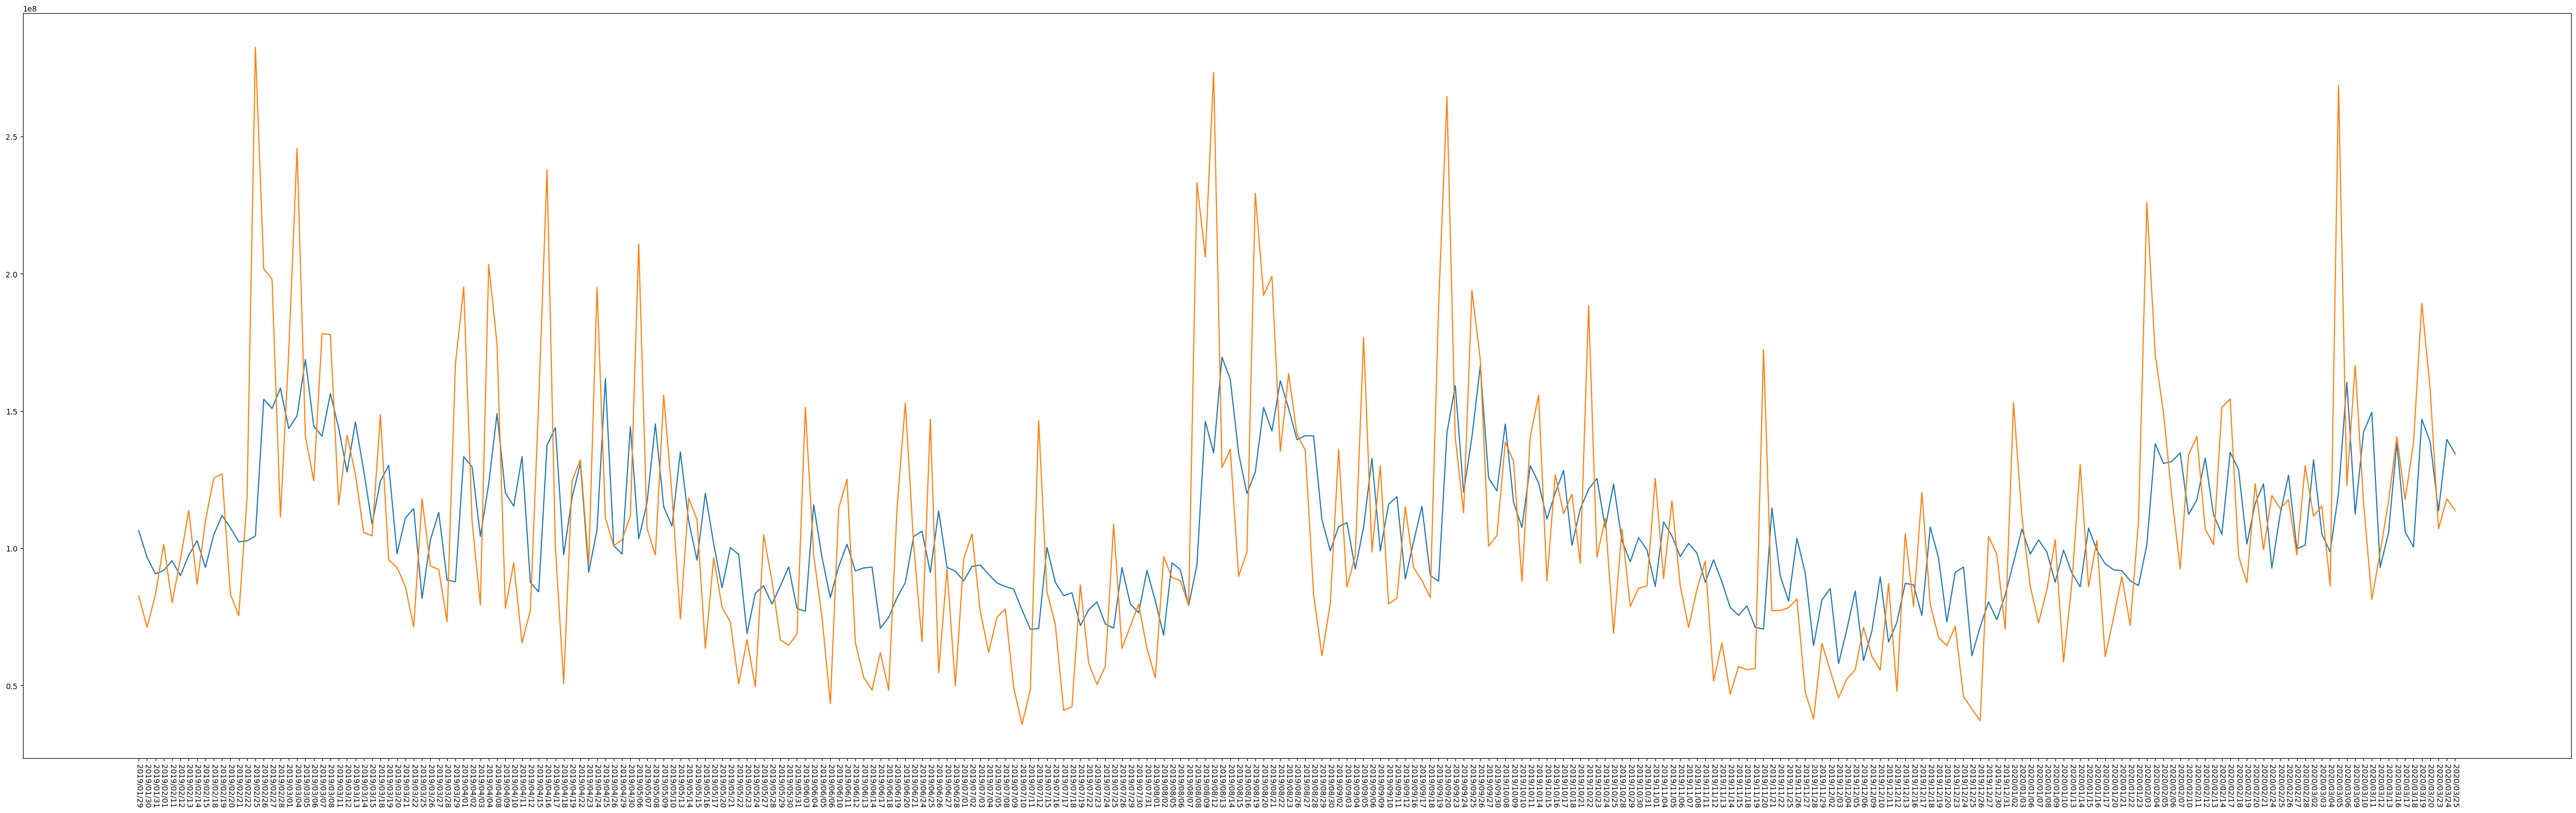

In [28]:
predict_data = arma.predict(start=time_series.index[0], end=time_series.index[-1], dynamic=False)
fig = plt.figure(figsize=(60, 18), dpi=100, facecolor="white")
plt.plot(predict_data)
plt.plot(time_series)
plt.xticks(rotation=-90)
plt.show()

In [25]:
# forcast=pd.DataFrame(arma_model.forecast(1)[0],index=table["1"].loc[-1:, :],columns=['forcastsales'])

n_steps = 21

f, err95, ci95 = arma.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = arma.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range("2020/04/03", periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), 
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), 
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2020-04-03,9.547614e+07,1.890897e+07,-5.150185e+06,1.720433e+08,1.961025e+08
2020-04-04,1.147737e+08,3.409410e+07,8.742726e+06,1.954533e+08,2.208047e+08
2020-04-05,1.318766e+08,4.950844e+07,2.362650e+07,2.142447e+08,2.401266e+08
2020-04-06,9.978579e+07,1.687082e+07,-9.182953e+06,1.827008e+08,2.087545e+08
2020-04-07,1.027880e+08,1.801494e+07,-8.622691e+06,1.875611e+08,2.141987e+08


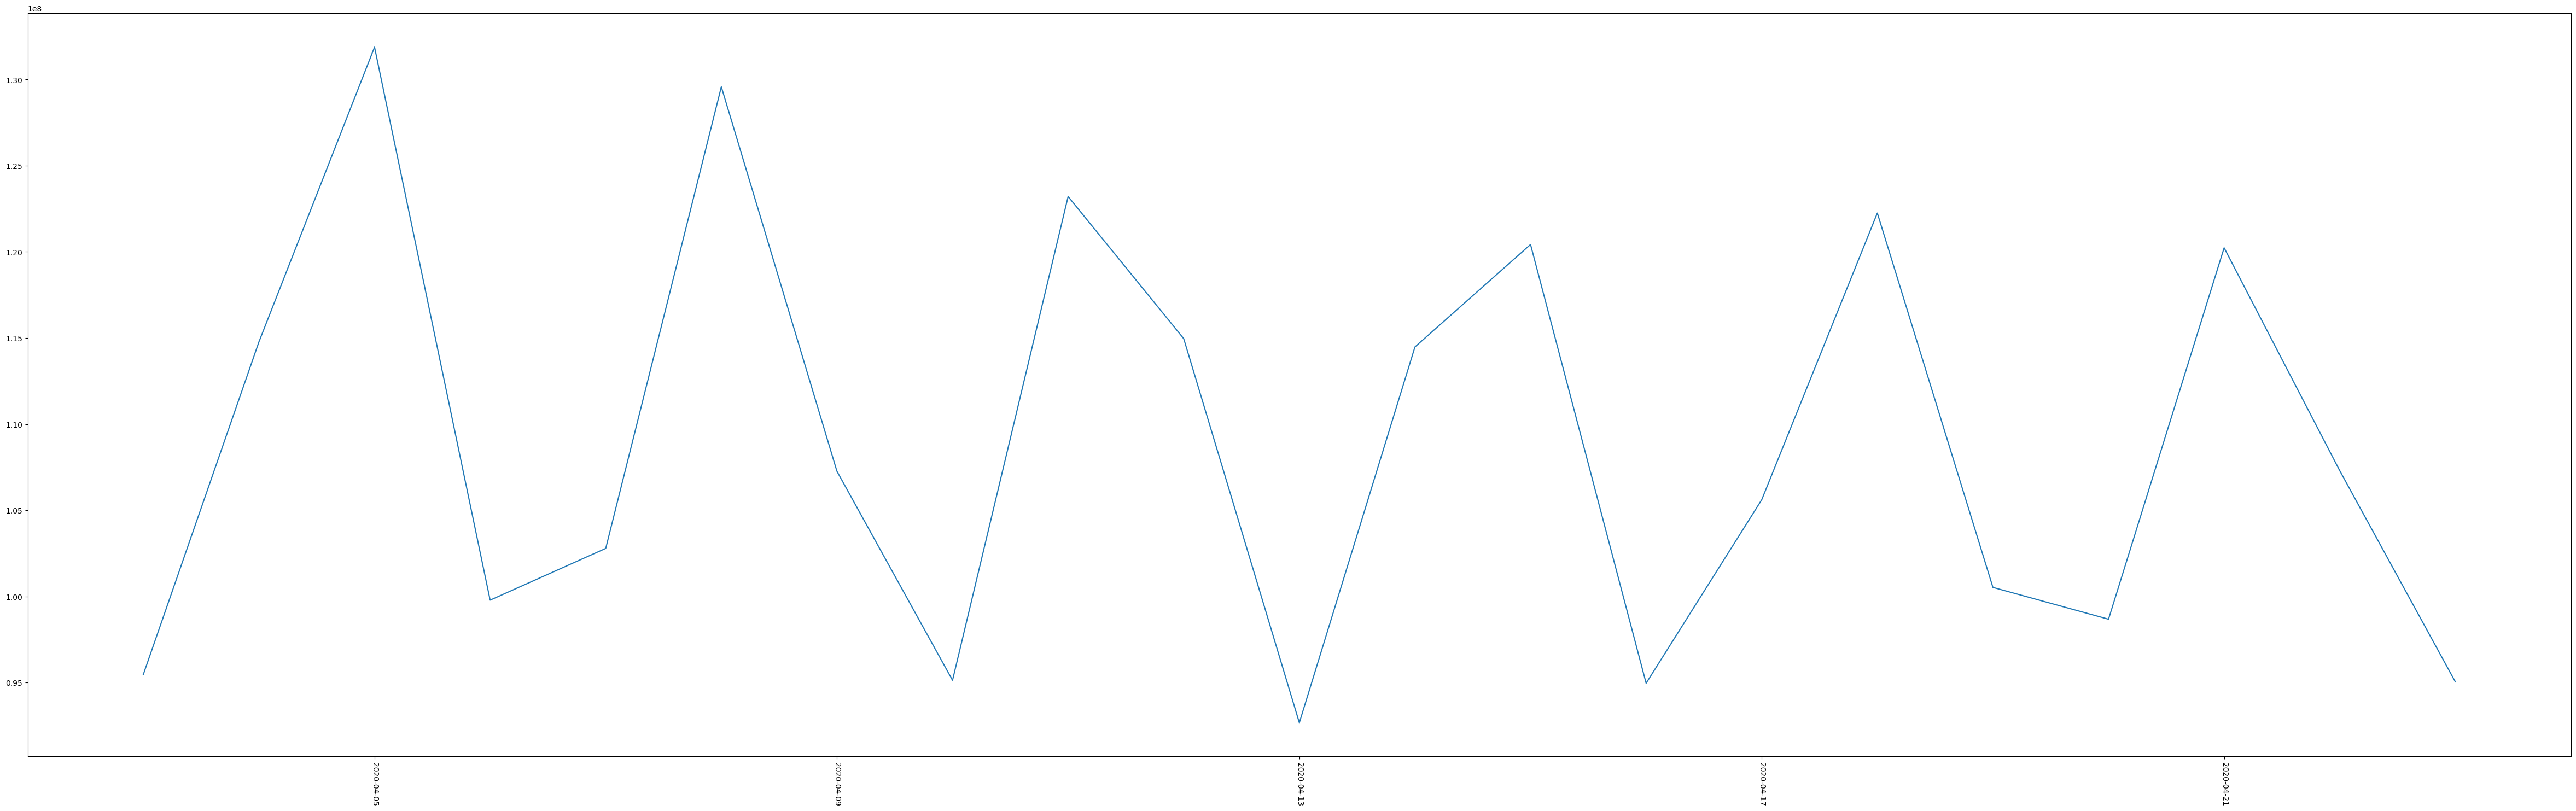

In [26]:
fig = plt.figure(figsize=(60, 18), dpi=100, facecolor="white")
plt.plot(fc_all.forecast)
plt.xticks(rotation=-90)
plt.show()

In [30]:
table = read_table()
data = table["1"].iloc[:-1,:]
data.index = pd.to_datetime(data['date'])
data.values

array([['2019/01/29', 10.96, 11.07, 10.77, 11.0, 82663112],
       ['2019/01/30', 10.95, 11.18, 10.86, 10.95, 71200104],
       ['2019/01/31', 10.98, 11.2, 10.94, 11.1, 83162272],
       ...,
       ['2020/03/23', 12.0, 12.35, 11.93, 12.15, 107111360],
       ['2020/03/24', 12.4, 12.68, 12.27, 12.61, 118020024],
       ['2020/03/25', 12.88, 13.07, 12.7, 12.87, 113695776]], dtype=object)

In [31]:
data.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume'], dtype='object')